# AutoEncoder2d Demo

Note: To use this demo, create the conda env defined in ``requirements-dev.conda.yaml``.


In this demo, we'll use the autoencoder model to encode and decode some images from the domain of histopathology. Sepcifically, patches from images of ovarian biopsies.

The data are available [here](https://www.kaggle.com/datasets/peymannejat/ovarian-cancer-pathology-patches). First, download them. Next, let list the images and obtain training and validation splits.

In [1]:
from pathlib import Path

from pandas import DataFrame

from torch_tools.file_utils import traverse_directory_tree


parent_dir = Path("/home/jim/storage/ovarian-histology/")

metadata = DataFrame(
    columns=["patch_path"],
    data=traverse_directory_tree(parent_dir),
)

metadata["patch_name"] = metadata.patch_path.apply(lambda x: x.name)
metadata["slide"] = metadata.patch_path.apply(lambda x: x.parent.name)

metadata = metadata.sort_values(by=["slide", "patch_name"])


valid_slides = metadata.slide.drop_duplicates().sample(n=3, random_state=123).to_list()

train_data = metadata.loc[~metadata.slide.isin(valid_slides)]
valid_data = metadata.loc[metadata.slide.isin(valid_slides)]


print(f"There are {len(train_data)} training patches")
print(f"There are {len(valid_data)} validation patches")

There are 6000 training patches
There are 3000 validation patches


Now that we have the metadata for the training and validation set, we can create data set and data loader objects.

In [2]:
from torch_tools import DataSet

from skimage.io import imread

from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, RandomCrop, ColorJitter


def input_tfms(training: bool) -> Compose:
    """Return a composition of input transforms.

    Parameters
    ----------
    training : bool
        Are we training, or validating?

    """
    tfm_list = [imread, ToTensor(), RandomCrop(128)]

    if training is True:
        tfm_list.append(
            ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        )

    return Compose(tfm_list)


train_set = DataSet(
    train_data.patch_path.to_list(),
    input_tfms=input_tfms(True),
)

valid_set = DataSet(
    valid_data.patch_path.to_list(),
    input_tfms=input_tfms(False),
)


bs = 8

train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=bs, shuffle=True)

In [3]:
from torch.cuda import is_available
from torch_tools import AutoEncoder2d


DEVICE = "cuda" if is_available() else "cpu"

model = AutoEncoder2d(
    in_chans=3,
    out_chans=3,
    block_style="conv_res",
    dropout=0.25,
).to(DEVICE)


print(model)

AutoEncoder2d(
  (encoder): Encoder2d(
    (0): ConvResBlock(
      (0): ConvBlock(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): ResidualBlock(
        (first_conv): ConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.0)
        )
        (second_conv): ConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (2): Dropout2d(p=0.25, inplace=False)
    )
    (1): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, di

Now, we set up the optimiser.

In [4]:
from torch.optim import Adam

optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

And now we write our training loop.

In [5]:
from typing import Optional, Dict
from torch.nn import Module

from torch import set_grad_enabled

from torch.nn.functional import l1_loss

from numpy import mean


def train_num_steps(
    model: Module,
    data_loader: DataLoader,
    num_steps: int,
    optimiser: Optional[Adam] = None,
) -> Dict[str, float]:
    """Train ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        AutoEncoder model.
    data_loader : DataLoader
        Training data loader.
    num_steps : int
        Number of steps to train or validate the model for.
    optimiser : Adam, optional
        Adam optimiser — only supply if training.

    Parameters
    ----------
    float
        Mean loss per item.

    """
    _ = model.train() if optimiser is not None else model.eval()

    losses = []

    steps = 0
    while steps < num_steps:

        for batch in data_loader:

            if not steps < num_steps:
                break

            if optimiser is not None:
                optimiser.zero_grad()

            batch = batch.to(DEVICE)

            with set_grad_enabled(optimiser is not None):
                preds = model(batch).tanh()

            loss = l1_loss(preds, batch)

            if optimiser is not None:
                loss.backward()
                optimiser.step()

            losses.append(loss.item())
            steps += 1

    return {"loss": mean(losses)}

Now we can train the model.

In [6]:
from time import perf_counter

from numpy import floor


total_steps = 10 ** 4

interval = 100

train_metrics, valid_metrics = [], []

steps = 0

while steps < total_steps:

    start_time = perf_counter()

    train_metrics.append(train_num_steps(model, train_loader, interval, optimiser))

    valid_metrics.append(
        train_num_steps(
            model,
            valid_loader,
            interval,
        )
    )

    stop_time = perf_counter()

    total_time = stop_time - start_time
    mins = floor(total_time / 60.0)
    secs = total_time % 60

    steps += interval

    print(f"Interval time: {mins:.2f} mins and {secs:.2f} seconds")


Interval time: 0.00 mins and 54.52 seconds
Interval time: 0.00 mins and 52.46 seconds
Interval time: 0.00 mins and 51.94 seconds
Interval time: 0.00 mins and 51.24 seconds
Interval time: 0.00 mins and 52.53 seconds
Interval time: 0.00 mins and 50.13 seconds
Interval time: 0.00 mins and 51.50 seconds
Interval time: 0.00 mins and 52.16 seconds
Interval time: 0.00 mins and 49.22 seconds
Interval time: 0.00 mins and 50.62 seconds
Interval time: 0.00 mins and 51.71 seconds
Interval time: 0.00 mins and 49.56 seconds
Interval time: 0.00 mins and 49.16 seconds
Interval time: 0.00 mins and 50.75 seconds
Interval time: 0.00 mins and 49.63 seconds
Interval time: 0.00 mins and 48.91 seconds
Interval time: 0.00 mins and 49.12 seconds
Interval time: 0.00 mins and 48.71 seconds
Interval time: 0.00 mins and 48.89 seconds
Interval time: 0.00 mins and 48.76 seconds
Interval time: 0.00 mins and 49.52 seconds
Interval time: 0.00 mins and 49.09 seconds
Interval time: 0.00 mins and 49.08 seconds
Interval ti

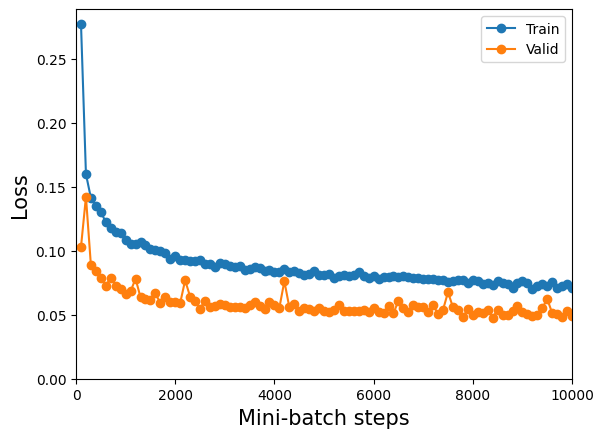

In [7]:
import matplotlib.pyplot as plt
from numpy import linspace


metrics = DataFrame(train_metrics).join(
    DataFrame(valid_metrics),
    lsuffix="_train",
    rsuffix="_valid",
)

figure, axes = plt.subplots(1, 1)

for key in ["train", "valid"]:
    axes.plot(
        linspace(1, len(metrics), len(metrics)) * interval,
        metrics[f"loss_{key}"],
        "-o",
        label=key.capitalize(),
    )

axes.set_ylim(bottom=0.0)
axes.set_xlim(left=0.0, right=len(metrics) * interval)

axes.set_xlabel("Mini-batch steps", fontsize=15)
axes.set_ylabel("Loss", fontsize=15)

axes.legend()

Now we can take a look at some predictions from the validation loader.


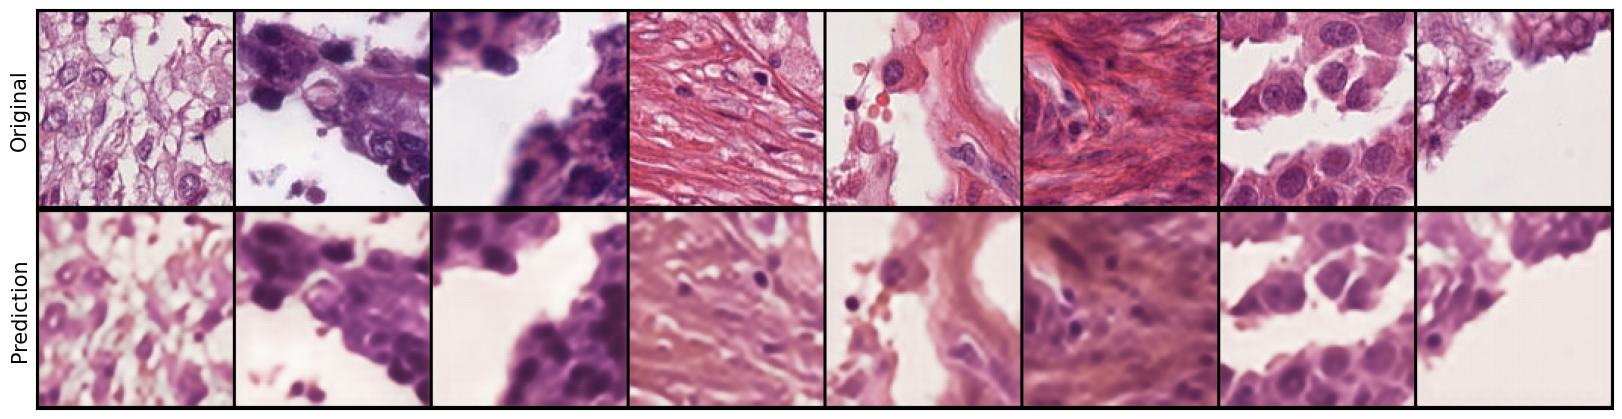

In [8]:
from torch import no_grad
from torchvision.utils import make_grid

with no_grad():
    model.eval()
    for batch in valid_loader:
        preds = model(batch.to(DEVICE)).tanh().clip(0.0, 1.0)
        break

batch_grid = make_grid(batch.cpu(), nrow=len(batch)).permute(1, 2, 0)
pred_grid = make_grid(preds.detach().cpu(), nrow=len(batch)).permute(1, 2, 0)


figure, axes = plt.subplots(2, 1, figsize=(len(batch) * 2, 4))
axes[0].imshow(batch_grid)
axes[1].imshow(pred_grid)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

axes[0].set_ylabel("Original", fontsize=15)
axes[1].set_ylabel("Prediction", fontsize=15)

figure.tight_layout(pad=0.01)

It is possible to improve the quality of the reconstructed images by training for longer, but since this is only a demo, we leave it here.